In [18]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Zadanie

Dysponujesz danymi z portalu Our World in Data dotyczącymi:
- Pierwotnej konsumpcji energii
- Emisji CO2 z poszczególnych lat dla różnych krajów

## Część 1: Plik CSV
Utwórz plik CSV zawierający połączone dane dla Polski:
- konsumpcja energii pierwotnej
- emisja CO2
- dane z poszczególnych lat

## Część 2: Plik Excel
Stwórz plik Excel z osobnymi zakładkami dla każdego kraju:
- UE
- USA
- Chiny
- Indie

Każda zakładka powinna zawierać dane o konsumpcji energii i emisji CO2.

## Część 3: Baza danych SQLite
Utwórz bazę danych SQLite z tabelą zawierającą:
- kraj
- rok
- emisja CO2
- konsumpcja energii

Dane powinny obejmować: Polskę, Niemcy i Hiszpanię.

## Część 4: Analiza i wizualizacja
Na podstawie danych z pliku Excel i bazy SQLite utwórz wykresy:
- emisja CO2 w zależności od roku (dla wybranego kraju)
- konsumpcja energii pierwotnej w zależności od roku (dla wybranego kraju)
- **dla chęnych szukanie koreacji**

In [19]:
import pandas as pd

df_co2 = pd.read_csv('/content/co2-emissions-per-capita.csv')
df_energy = pd.read_csv('/content/primary-energy-cons.csv')

df_co2.columns = [c.strip().lower().replace(" ", "_") for c in df_co2.columns]
df_energy.columns = [c.strip().lower().replace(" ", "_") for c in df_energy.columns]

df_co2.rename(columns={'annual_co₂_emissions_(per_capita)': 'co2_per_capita'}, inplace=True)
df_energy.rename(columns={'primary_energy_consumption_(twh)': 'energy_twh'}, inplace=True)

merged = pd.merge(df_co2, df_energy, on=['entity', 'year'], how='inner')

polska = merged[merged['entity'].str.lower() == 'poland']

polska = polska[['year', 'energy_twh', 'co2_per_capita']].sort_values(by='year')

output_path = 'polska_energia_co2.csv'
polska.to_csv(output_path, index=False, encoding='utf-8')
print(polska.head(10))


      year  energy_twh  co2_per_capita
7387  1965   776.05330        7.893703
7388  1966   791.17820        7.996349
7389  1967   814.29987        8.138128
7390  1968   876.36676        8.597721
7391  1969   936.06604        9.076116
7392  1970   987.92114        9.345997
7393  1971  1019.14355        9.547403
7394  1972  1074.91880        9.972351
7395  1973  1095.06400       10.067717
7396  1974  1131.25630       10.291654


In [20]:
kraje = {
    'UE': 'European Union (27)',
    'USA': 'North America (excl. USA)',
    'Chiny': 'China',
    'Indie': 'India'
}

output_path = '/content/energia_co2_kraje.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    for nazwa_arkusza, nazwa_kraju in kraje.items():
        dane_kraju = merged[merged['entity'].str.lower() == nazwa_kraju.lower()]
        dane_kraju = dane_kraju[['year', 'energy_twh', 'co2_per_capita']].sort_values(by='year')
        dane_kraju.to_excel(writer, sheet_name=nazwa_arkusza, index=False)

print(f"\nplik Excel: {output_path}")


plik Excel: /content/energia_co2_kraje.xlsx


In [26]:
import sqlite3

print("=== Kolumny w pliku CO2 ===")
print(df_co2.columns.tolist())
print("\n=== Kolumny w pliku ENERGIA ===")
print(df_energy.columns.tolist())

kol_emisja = [c for c in df_co2.columns if 'co2' in c][0]
kol_energia = [c for c in df_energy.columns if 'energy' in c or 'consumption' in c][0]

print(f"\n Kolumna emisji CO2: {kol_emisja}")
print(f" Kolumna energii: {kol_energia}")

merged = pd.merge(df_co2, df_energy, on=['entity', 'year'], how='inner')

kraje_map = {
    'Poland': 'Polska',
    'Germany': 'Niemcy',
    'Spain': 'Hiszpania'
}

dane_lista = []
for nazwa_w_pliku, nazwa_pl in kraje_map.items():
    df_kraj = merged[merged['entity'] == nazwa_w_pliku][['year', kol_emisja, kol_energia]].copy()
    df_kraj.columns = ['year', 'emisja_co2', 'konsumpcja_energii']
    df_kraj['kraj'] = nazwa_pl
    dane_lista.append(df_kraj)

dane_finalne = pd.concat(dane_lista, ignore_index=True)
dane_finalne = dane_finalne[['kraj', 'year', 'emisja_co2', 'konsumpcja_energii']].sort_values(['kraj', 'year'])

print("\n Podgląd danych do zapisu:")
print(dane_finalne.head(10))

baza_path = '/content/energia_co2.db'
conn = sqlite3.connect(baza_path)

dane_finalne.to_sql('energia_co2', conn, if_exists='replace', index=False)

print("\n Dane z bazy:")
print(pd.read_sql_query("SELECT * FROM energia_co2 LIMIT 10;", conn))

conn.close()
print(f"\n Utworzono bazę danych: {baza_path}")


=== Kolumny w pliku CO2 ===
['entity', 'year', 'co2_per_capita']

=== Kolumny w pliku ENERGIA ===
['entity', 'code', 'year', 'energy_twh']

 Kolumna emisji CO2: co2_per_capita
 Kolumna energii: energy_twh

 Podgląd danych do zapisu:
          kraj  year  emisja_co2  konsumpcja_energii
118  Hiszpania  1965    2.211740           337.40662
119  Hiszpania  1966    2.390725           381.80264
120  Hiszpania  1967    2.632297           411.54218
121  Hiszpania  1968    2.924838           433.01935
122  Hiszpania  1969    2.887934           490.20828
123  Hiszpania  1970    3.453330           528.76056
124  Hiszpania  1971    3.760778           582.20070
125  Hiszpania  1972    4.189833           629.56250
126  Hiszpania  1973    4.436667           689.23780
127  Hiszpania  1974    4.882836           717.36750

 Dane z bazy:
        kraj  year  emisja_co2  konsumpcja_energii
0  Hiszpania  1965    2.211740           337.40662
1  Hiszpania  1966    2.390725           381.80264
2  Hiszpania  19

=== Dane z Excela (Chiny) ===
   year  energy_twh  co2_per_capita
0  1965   1536.1942        0.691561
1  1966   1669.3080        0.740110
2  1967   1501.0684        0.604744
3  1968   1516.6958        0.634442
4  1969   1845.1862        0.757577 

=== Dane z bazy SQLite (Polska) ===
     kraj  year  emisja_co2  konsumpcja_energii
0  Polska  1965    7.893703           776.05330
1  Polska  1966    7.996349           791.17820
2  Polska  1967    8.138128           814.29987
3  Polska  1968    8.597721           876.36676
4  Polska  1969    9.076116           936.06604 



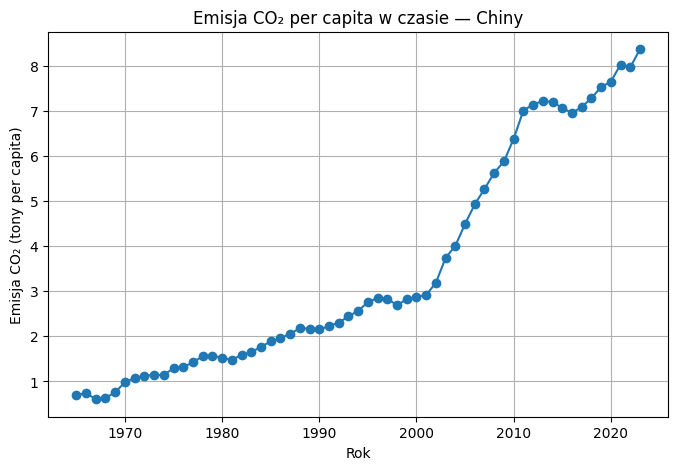

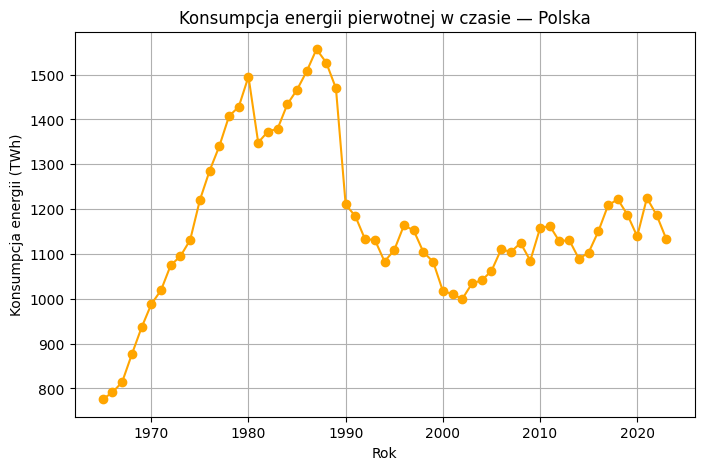

In [27]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

kraj_excel = 'Chiny'
kraj_sqlite = 'Polska'

sciezka_excel = '/content/energia_co2_kraje.xlsx'
excel_dane = pd.read_excel(sciezka_excel, sheet_name=kraj_excel)

sciezka_baza = '/content/energia_co2.db'
conn = sqlite3.connect(sciezka_baza)
sql_dane = pd.read_sql_query(f"SELECT * FROM energia_co2 WHERE kraj = '{kraj_sqlite}'", conn)
conn.close()

print(f"=== Dane z Excela ({kraj_excel}) ===")
print(excel_dane.head(), "\n")

print(f"=== Dane z bazy SQLite ({kraj_sqlite}) ===")
print(sql_dane.head(), "\n")

plt.figure(figsize=(8, 5))
plt.plot(excel_dane['year'], excel_dane['co2_per_capita'], marker='o')
plt.title(f'Emisja CO₂ per capita w czasie — {kraj_excel}')
plt.xlabel('Rok')
plt.ylabel('Emisja CO₂ (tony per capita)')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(sql_dane['year'], sql_dane['konsumpcja_energii'], color='orange', marker='o')
plt.title(f'Konsumpcja energii pierwotnej w czasie — {kraj_sqlite}')
plt.xlabel('Rok')
plt.ylabel('Konsumpcja energii (TWh)')
plt.grid(True)
plt.show()
